## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images. The normalisation - mean and standard deviation values are set based on the mean and standard deviation calculated on the train dataset which can seen down below. 

In [5]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3195739..2.742625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.145514..2.742625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8496122..2.742625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3195739..2.692327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.215138..2.742625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.302168..2.675561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3195739..2.2991

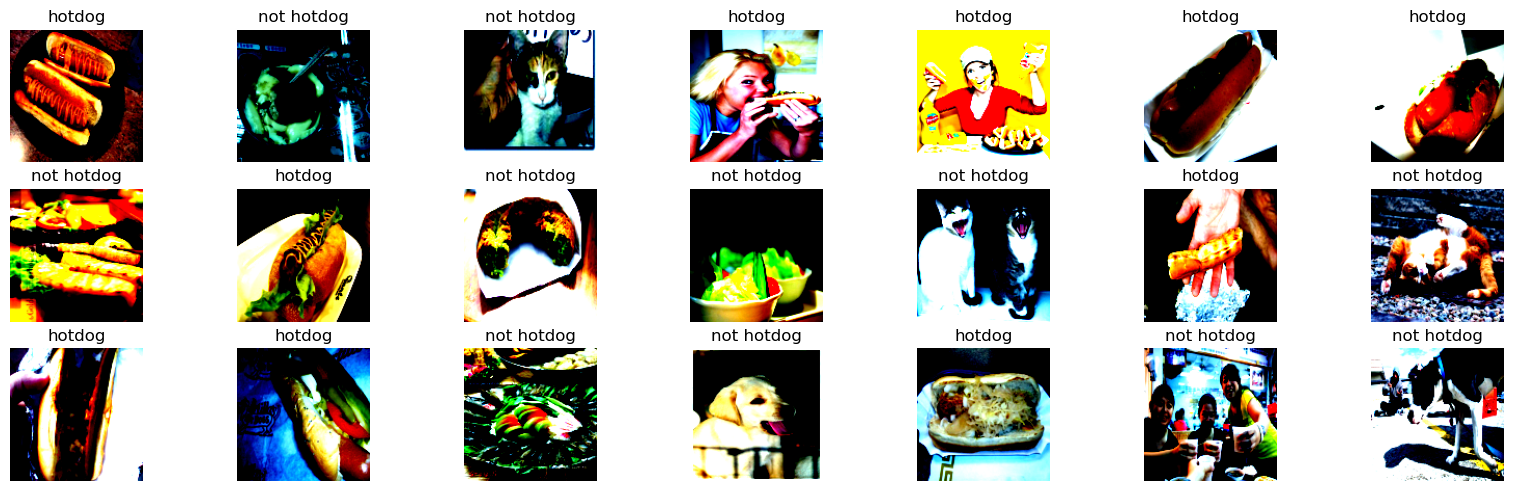

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


### EDA

In [7]:
targets_train = [label for _, label in trainset]
targets_test = [label for _, label in testset]

In [8]:
hotdogs_train, hotdogs_test, not_hotdogs_train, not_hotdogs_test = sum(targets_train), sum(targets_test), len(targets_train) - sum(targets_train), len(targets_test) - sum(targets_test)
print(f"Hotdogs in the train set: {hotdogs_train}")
print(f"Not hotdogs in the train set: {not_hotdogs_train}")
print(f"Hotdogs in the test set: {hotdogs_test}")
print(f"Not hotdogs in the test set: {not_hotdogs_test}")


Hotdogs in the train set: 972
Not hotdogs in the train set: 1075
Hotdogs in the test set: 967
Not hotdogs in the test set: 895


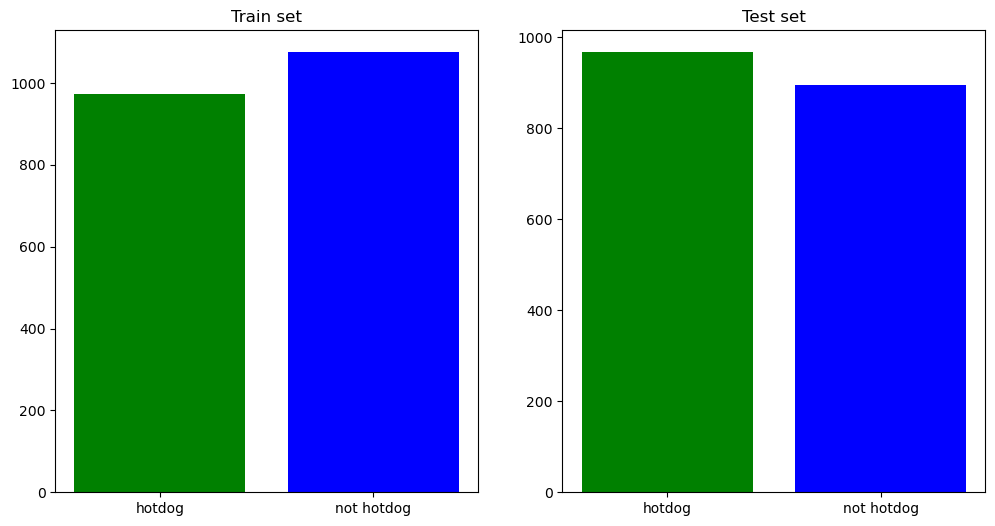

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(['hotdog', 'not hotdog'], [hotdogs_train, not_hotdogs_train], color = ['green', 'blue'])
ax[0].set_title('Train set')
ax[1].bar(['hotdog', 'not hotdog'], [hotdogs_test, not_hotdogs_test], color = ['green', 'blue'])
ax[1].set_title('Test set')
plt.show()

In [10]:
images, labels = next(iter(train_loader))

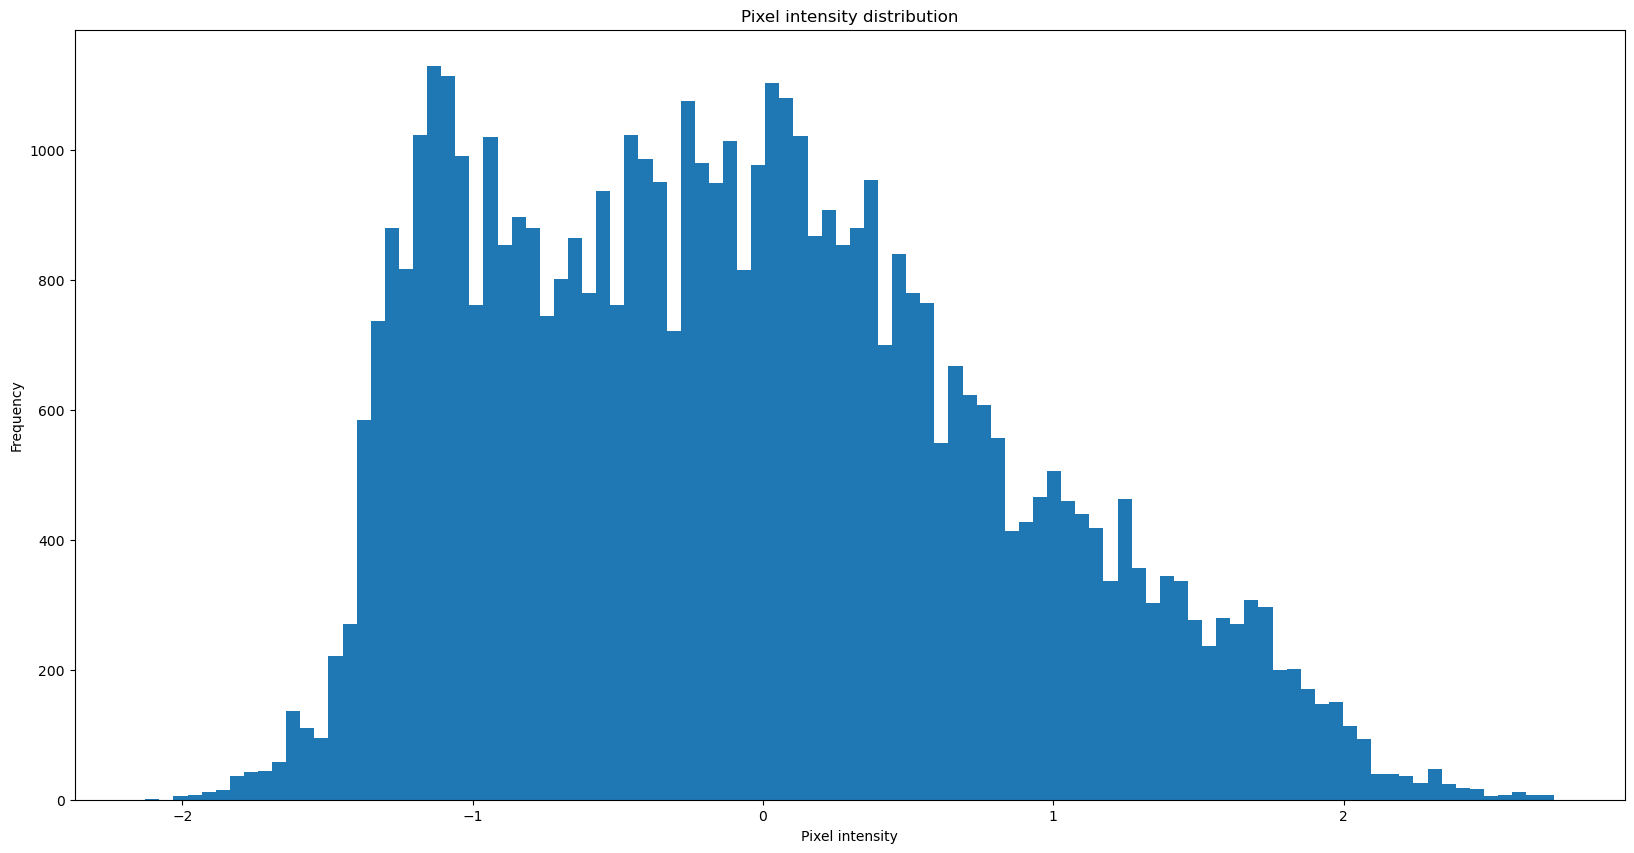

In [11]:
# plot pixel intensity distribution
plt.figure(figsize=(20,10))
plt.hist(images[0].numpy().flatten(), bins=100)
plt.title('Pixel intensity distribution')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Calculate the mean and standard deviation of the pixel intensities
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in tqdm(train_loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
mean /= nb_samples
std /= nb_samples
print(f'Mean: {mean} and Standard Deviation: {std} for the train set')  

# Mean: tensor([0.5226, 0.4412, 0.3585]) and Standard Deviation: tensor([0.2253, 0.2294, 0.2339]) for the train set
# so we normalise the data with these values in the transforms


Mean: tensor([-1.0818e-04, -8.6452e-05, -1.8219e-04]) and Standard Deviation: tensor([1.0001, 0.9998, 0.9998]) for the train set


The above mean is now close to 0. This indicates that your data is centered around zero, which helps training neural networks with faster convergence. Now, the standard deviation is close to 1. This shows that the data is scaled properly. 

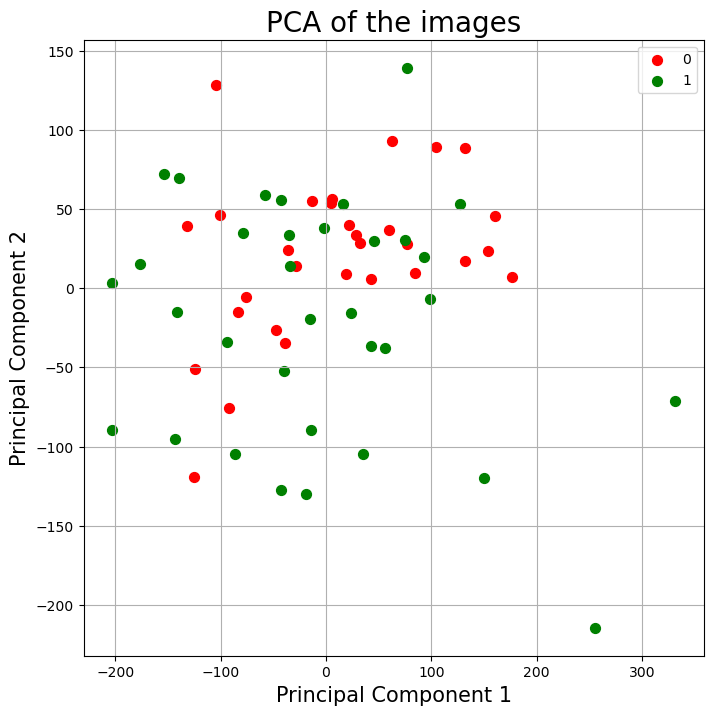

In [14]:
# calculate the PCA of the images in the train set
def plot_pca(data, labels, title):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    principalDf['target'] = labels
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['target'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()
data = images.view(images.size(0), -1).numpy()
scaler = StandardScaler()
data = scaler.fit_transform(data)
plot_pca(data, labels, 'PCA of the images')


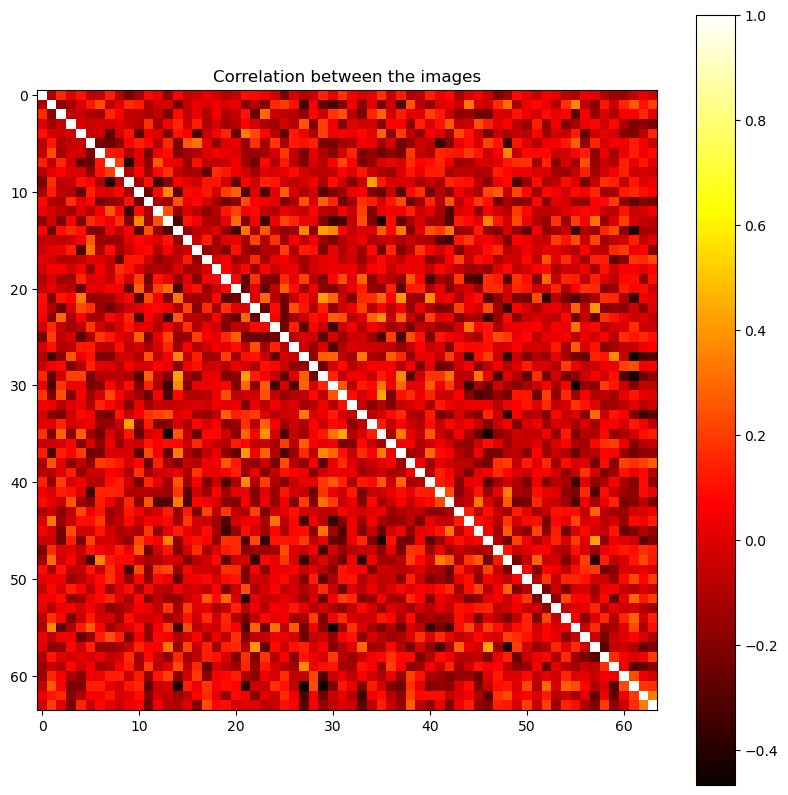

In [15]:
# calculating the correlation between the images in the train set
correlation = np.corrcoef(data)
plt.figure(figsize=(10, 10))
plt.imshow(correlation, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Correlation between the images')
plt.show()

In [16]:
# calculating the statistics of the correlation

mean_correlation = np.mean(correlation)
median_correlation = np.median(correlation)
max_correlation = np.max(correlation)
min_correlation = np.min(correlation)
std_correlation = np.std(correlation)

high_corr_threshold = 0.9  
num_high_corr = np.sum(correlation > high_corr_threshold) - len(correlation)  
total_pairs = len(correlation) * (len(correlation) - 1)  
percentage_high_corr = (num_high_corr / total_pairs) * 100

low_corr_threshold = 0.1
num_low_corr = np.sum(np.abs(correlation) < low_corr_threshold) - len(correlation)  
percentage_low_corr = (num_low_corr / total_pairs) * 100

print(f"Mean correlation between images: {mean_correlation:.4f}")
print(f"Median correlation between images: {median_correlation:.4f}")
print(f"Maximum correlation: {max_correlation:.4f}")
print(f"Minimum correlation: {min_correlation:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")
print(f"Percentage of highly correlated pairs: {percentage_high_corr:.2f}%")
print(f"Percentage of low correlated pairs: {percentage_low_corr:.2f}%")

Mean correlation between images: 0.0007
Median correlation between images: -0.0161
Maximum correlation: 1.0000
Minimum correlation: -0.4673
Standard deviation of correlation: 0.1915
Percentage of highly correlated pairs: 0.00%
Percentage of low correlated pairs: 49.55%


Observations from the correlations:

Mean=0.0007 -indicates minimal overall correlation between images.

Median correlation = -0.0161 -  more than half of the image pairs have weak correlation.

Maximum correlation =1.0000 - at least two images are  similar.

Minimum correlation=-0.4673 - shows that there some images which are negatively correlated. 

Standard deviation of correlation = 0.1915 - spread of correlations is small which means that most images are weakly correlated.

Percentage of highly correlated pairs= 0.00% - image pairs have a high correlation showing no redundancy in the dataset.

Percentage of low correlated pairs= 49.55% - atmost half of the image pairs have very low correlation.

Now create a model and train it!


In [17]:
class Network(nn.Module):
    def __init__(self, num_epochs, learning_rate, batch_size):
        super(Network, self).__init__()
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self.criterion = nn.CrossEntropyLoss()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(32*32*32, 128), # 32*32*32 is the size of the tensor after the convolutional part because of the maxpooling
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
    def run(self, train_loader, test_loader):

        for epoch in tqdm(range(self.num_epochs), unit= 'epoch'):
        #for each epoch
            train_correct = 0
            loss_total = 0

            for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
                self.train()
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self(data)
                loss = self.criterion(output, target)
                loss_total+= loss.detach().cpu().item()
                loss.backward()
                self.optimizer.step()
                predicted = output.argmax(dim=1)
                train_correct += (target == predicted).sum().cpu().item()

        #test accuracy
            test_correct = 0
            for data, target in test_loader:
                self.eval()
                data = data.to(device)
                with torch.no_grad():
                    output = self(data)
                predicted = output.argmax(dim=1).cpu()
                test_correct += (predicted == target).sum().cpu().item()
                
            test_acc = test_correct/len(testset)
            
            train_acc = train_correct/len(trainset)
            
            print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))


In [18]:
num_epochs = 5
learning_rate = 0.001
batch_size = 64
model = Network(num_epochs, learning_rate, batch_size).to(device)
model.run(train_loader, test_loader)


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 58.9%	 test: 69.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 77.0%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 82.2%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 86.2%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 91.2%	 test: 75.4%


### TESTING

In [19]:
class Network_(nn.Module):
    def __init__(self):
        super(Network_, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(32*32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [20]:
model = Network_()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [21]:
num_epochs = 5
train_accuracy, test_accuracy = [], []
losses = []

model.to(device) #to  move the model to the GPU

for epoch in tqdm(range(num_epochs), unit= 'epoch'):
    #for each epoch
    train_correct = 0
    loss_total = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        model.train()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad
        output = model(data)
        loss = criterion(output, target)
        loss_total+= loss.detach().cpu().item()
        loss.backward()
        optimizer.step()
        predicted = output.argmax(dim=1)
        train_correct += (target == predicted).sum().cpu().item()

    losses.append(loss_total)

    #test accuracy
    test_correct = 0
    for data, target in test_loader:
        model.eval()
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(dim=1).cpu()
        test_correct += (predicted == target).sum().cpu().item()
        
    test_acc = test_correct/len(testset)
    test_accuracy.append(test_acc)
    train_acc = train_correct/len(trainset)
    train_accuracy.append(train_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

    




  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 62.8%	 test: 68.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 66.5%	 test: 57.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 54.0%	 test: 68.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 73.2%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 74.0%	 test: 69.9%


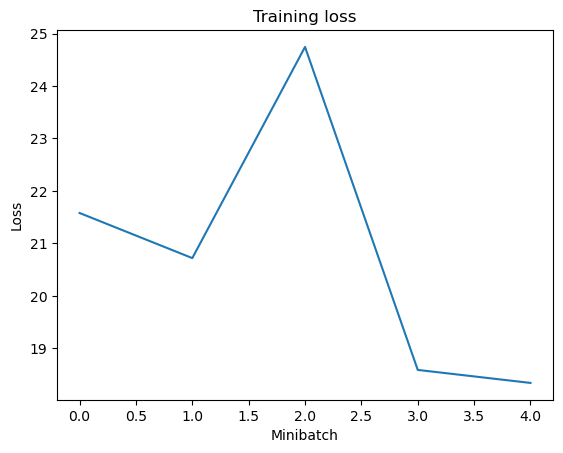

In [22]:
#plot losses
plt.plot(losses)
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

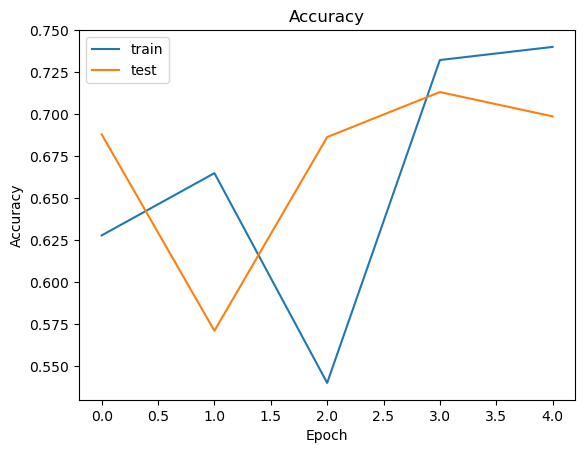

In [23]:
#plot accuracy
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [24]:
#demo